In [1]:
import numpy as np
import cv2

from scipy.misc import imread, imsave
import glob

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.svm import SVC
from scipy.ndimage.measurements import label

#plotting
from matplotlib import pyplot as plt
import seaborn as sns
from IPython.core.debugger import Tracer
import warnings
from jupyterthemes import jtplot

#parallel execution
from joblib import Parallel, delayed
import multiprocessing

#user code
import features as FEATURES
from color_histogram import color_hist
from utils import draw_boxes
import search

In [2]:
%matplotlib inline
jtplot.style()
sns.set_context("poster")
# plt.style.use('fivethirtyeight')
warnings.filterwarnings("ignore")

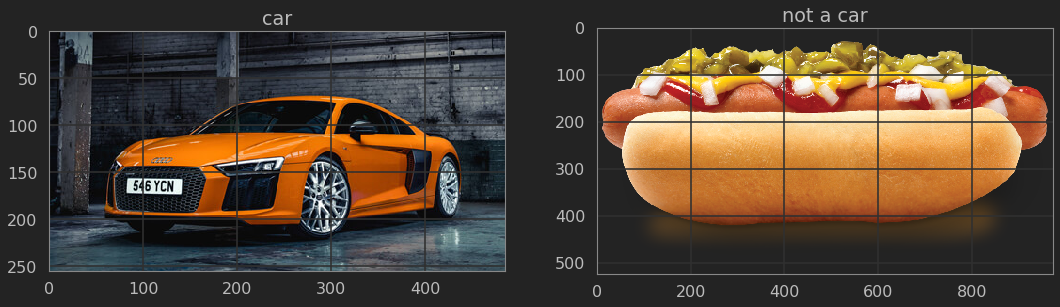

In [35]:
r8 = imread("r8.jpg")
hotdog = imread("hot_dog.png")
plt.figure(figsize=(18,5))
plt.subplot(121)
plt.title("car")
plt.imshow(r8)
plt.subplot(122)
plt.title("not a car")
plt.imshow(hotdog)

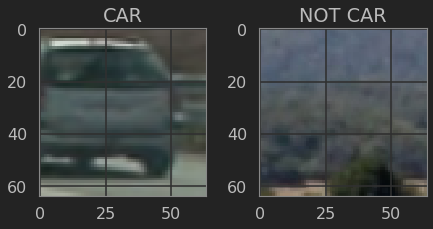

{'n_cars': 8792, 'n_notcars': 8968, 'image_shape': (64, 64, 3), 'data_type': dtype('uint8')}


In [18]:
#read in training data
cars = glob.glob('data/vehicles/**/*.png', recursive=True)
not_cars = glob.glob('data/non-vehicles/**/*.png', recursive=True)
data = np.concatenate([cars, not_cars])
data_dict = {}
data_dict["n_cars"] = len(cars)
data_dict["n_notcars"] = len(not_cars)
car = imread(cars[np.random.randint(len(cars))])
notacar = imread(not_cars[np.random.randint(len(not_cars))])
data_dict["image_shape"] = car.shape
data_dict["data_type"] = car.dtype

plt.subplot(121)
plt.title("CAR")
plt.imshow(car)
plt.subplot(122)
plt.title("NOT CAR")
plt.imshow(notacar)
plt.tight_layout()
plt.show()
print(data_dict)
imsave("example_car.png", car)
imsave("example_notacar.png", notacar)

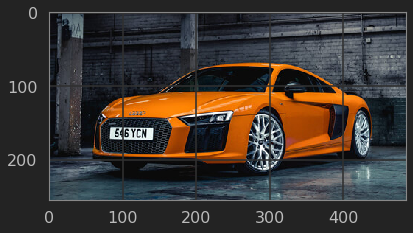

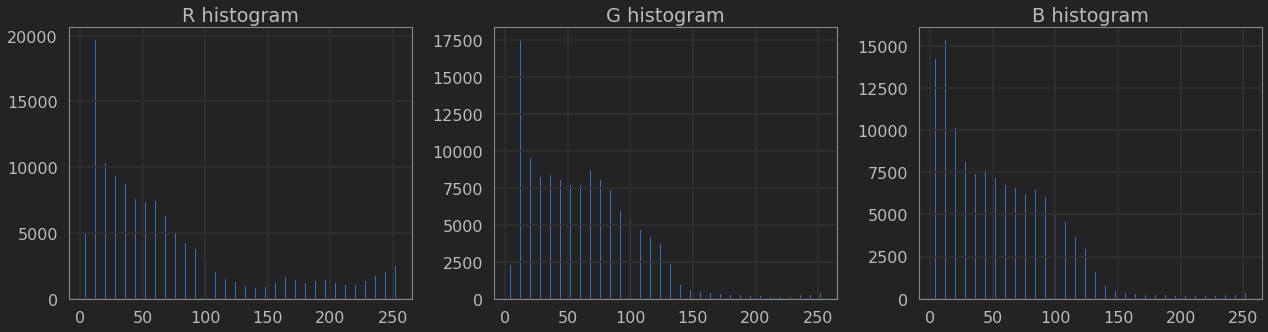

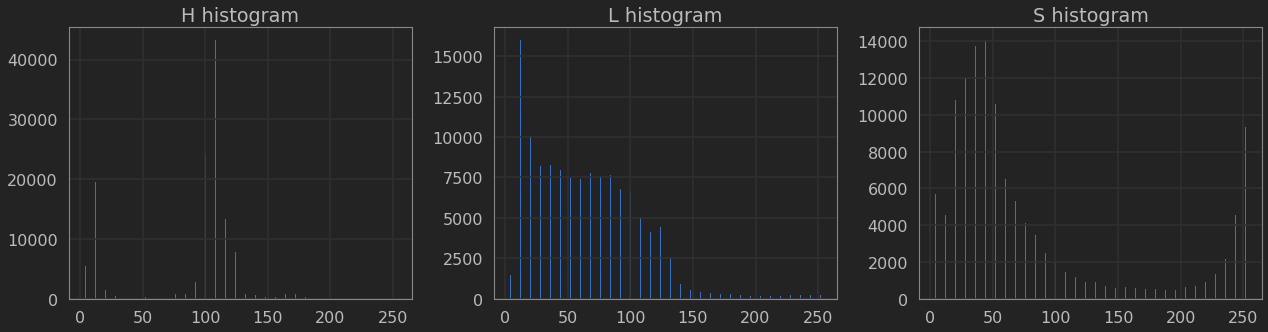

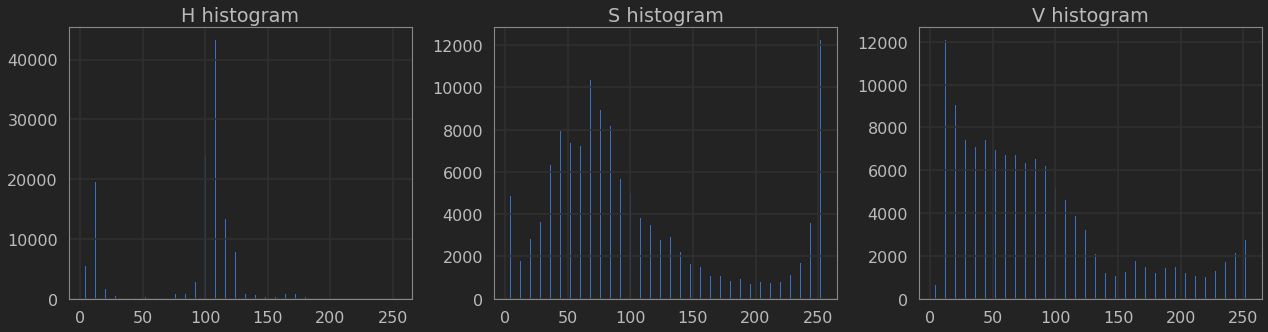

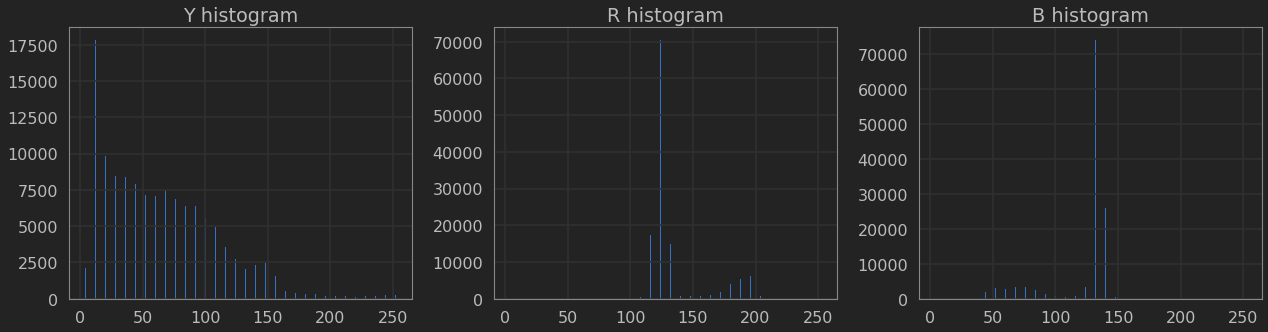

In [36]:
#lets look at the saturtion channel
test_image = r8
plt.imshow(test_image)
test_image_hls = cv2.cvtColor(test_image, cv2.COLOR_RGB2HLS)
test_image_hsv = cv2.cvtColor(test_image, cv2.COLOR_RGB2HSV)
test_image_crayon = cv2.cvtColor(test_image, cv2.COLOR_RGB2YCrCb)

def show_histogram(image, title):
    #extract histogram features
    histogram_data = color_hist(image)
    plt.figure(figsize=(18,5))
    for i in range(3):
        data, points = histogram_data[i]
        plt.subplot(131 + i)
        plt.bar(points, data)
        plt.title(title[i] + " histogram")
    plt.tight_layout()
    plt.show()

plt.figure(figsize=(18,5))
show_histogram(test_image, "RGB")
plt.figure(figsize=(18,5))
show_histogram(test_image_hls, "HLS")
plt.figure(figsize=(18,5))
show_histogram(test_image_hsv, "HSV")
plt.figure(figsize=(18,5))
show_histogram(test_image_crayon, "YRB")

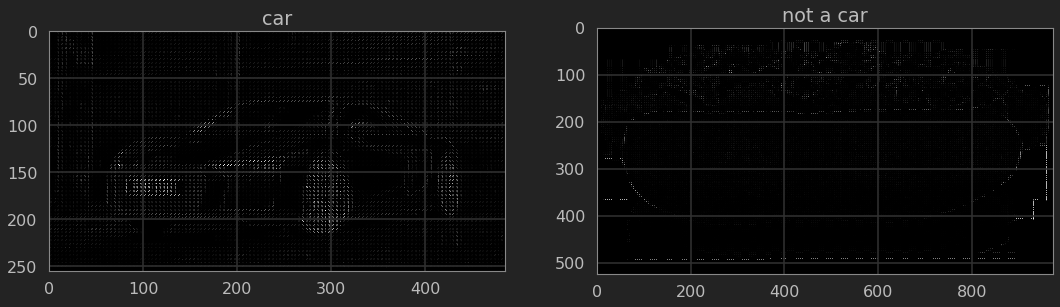

In [39]:
##### extract hog features
from skimage.feature import hog
plt.figure(figsize=(18,5))

plt.subplot(121)
plt.title("car")
test_image_hls = cv2.cvtColor(r8, cv2.COLOR_RGB2HLS)
hog_output = features = hog(test_image_hls[:,:,1], orientations=9, 
                   pixels_per_cell=(4,4), 
                   cells_per_block=(2,2) ,
                   visualise=True)

plt.imshow(hog_output[1],cmap="gray")
test_image_hls = cv2.cvtColor(test_image, cv2.COLOR_RGB2HLS)
plt.subplot(122)
plt.title("not a car")
test_image_hls = cv2.cvtColor(hotdog, cv2.COLOR_RGB2HLS)
hog_output = features = hog(test_image_hls[:,:,1], orientations=9, 
                   pixels_per_cell=(4,4), 
                   cells_per_block=(2,2) ,
                   visualise=True)

plt.imshow(hog_output[1],cmap="gray")

In [8]:
def featurizer(image, features):
    output = []
    for feature in features:
        output.append(feature(image))
        
    return np.concatenate(output)

In [9]:
features = [
    lambda x: FEATURES.color(x, 1, "HLS"),
    lambda x: FEATURES.color(x, 2, "HLS"),
    lambda x: FEATURES.color(x, 1, "HSV"),
    lambda x: FEATURES.color(x, 2, "HSV"),
    lambda x: FEATURES.HOG(x)
]


In [10]:
#process the data in parallel
num_cores = multiprocessing.cpu_count()
def processor(image_file_path):
    return featurizer(imread(image_file_path), features)
    
car_features = np.array(Parallel(n_jobs=num_cores)(
        delayed(processor)(i) for i in cars
    ), dtype=np.float32)

notcar_features = np.array(Parallel(n_jobs=num_cores)(
        delayed(processor)(i) for i in not_cars
    ), dtype=np.float32)

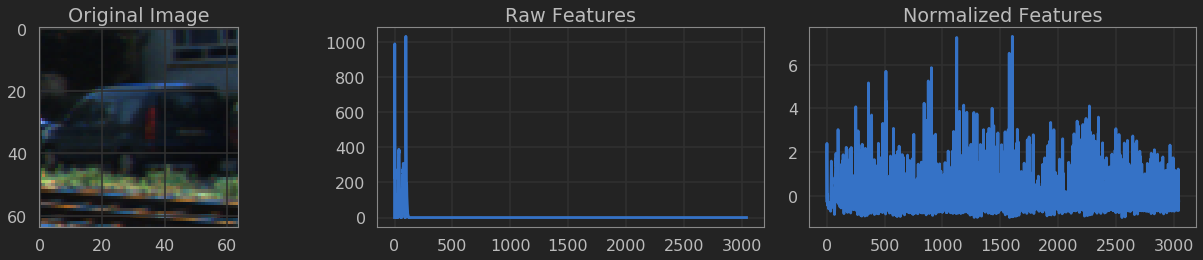

In [11]:
#normalize the data
# Create an array stack of feature vectors
X = np.vstack((car_features, notcar_features))                      
# Fit a per-column scaler
X_scaler = StandardScaler().fit(X)
# Apply the scaler to X
scaled_X = X_scaler.transform(X)
car_ind = np.random.randint(0, len(car_features))

# Plot an example of raw and scaled features
fig = plt.figure(figsize=(18,4))
plt.subplot(131)
plt.imshow(imread(cars[car_ind]))
plt.title('Original Image')
plt.subplot(132)
plt.plot(X[car_ind])
plt.title('Raw Features')
plt.subplot(133)
plt.plot(scaled_X[car_ind])
plt.title('Normalized Features')
plt.tight_layout()


In [12]:
#create the dataset
labels = np.hstack([np.ones(len(cars)), np.zeros(len(not_cars))]).astype(np.float32)
X_train, X_test, y_train, y_test = train_test_split(scaled_X, labels, test_size=0.33, random_state=42)

In [13]:
#lets tune the SVM classifier
C_range = np.logspace(-2, 10, 13)
gamma_range = np.logspace(-9, 3, 13)

parameters = {'C':C_range}
svr = SVC()
clf = GridSearchCV(svr, parameters)
clf.fit(X_train[:1000], y_train[:1000])


AttributeError: 'GridSearchCV' object has no attribute 'best_params'

In [14]:
clf.best_params_

{'C': 10.0}

In [15]:
#results of the search is a C value of 10 and auto gamma, rbf network
clf = SVC(C=10)
clf.fit(X_train, y_train)

SVC(C=10, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [16]:
predictions = clf.predict(X_test)

In [17]:
#best with gamma=auto, C-10, rbf -> 0.98242620713188877
acc = sum([p == a for (p, a) in zip(predictions, y_test)])/float(len(y_test))
acc

0.98993345845418868

In [25]:
#lets save this SVC so we did have to learn to scale and fit this every time we load
import pickle
project_classifier = {
    "clf": clf,
    "X_scaler": X_scaler,
    "acc": acc
}

with open("project_classifier.pkl", "wb") as f:
    pickle.dump(project_classifier, f)

In [22]:
def predict(image):
    x = X_scaler.transform(featurizer(image, features).reshape(1,-1))
    return clf.predict(x)[0]

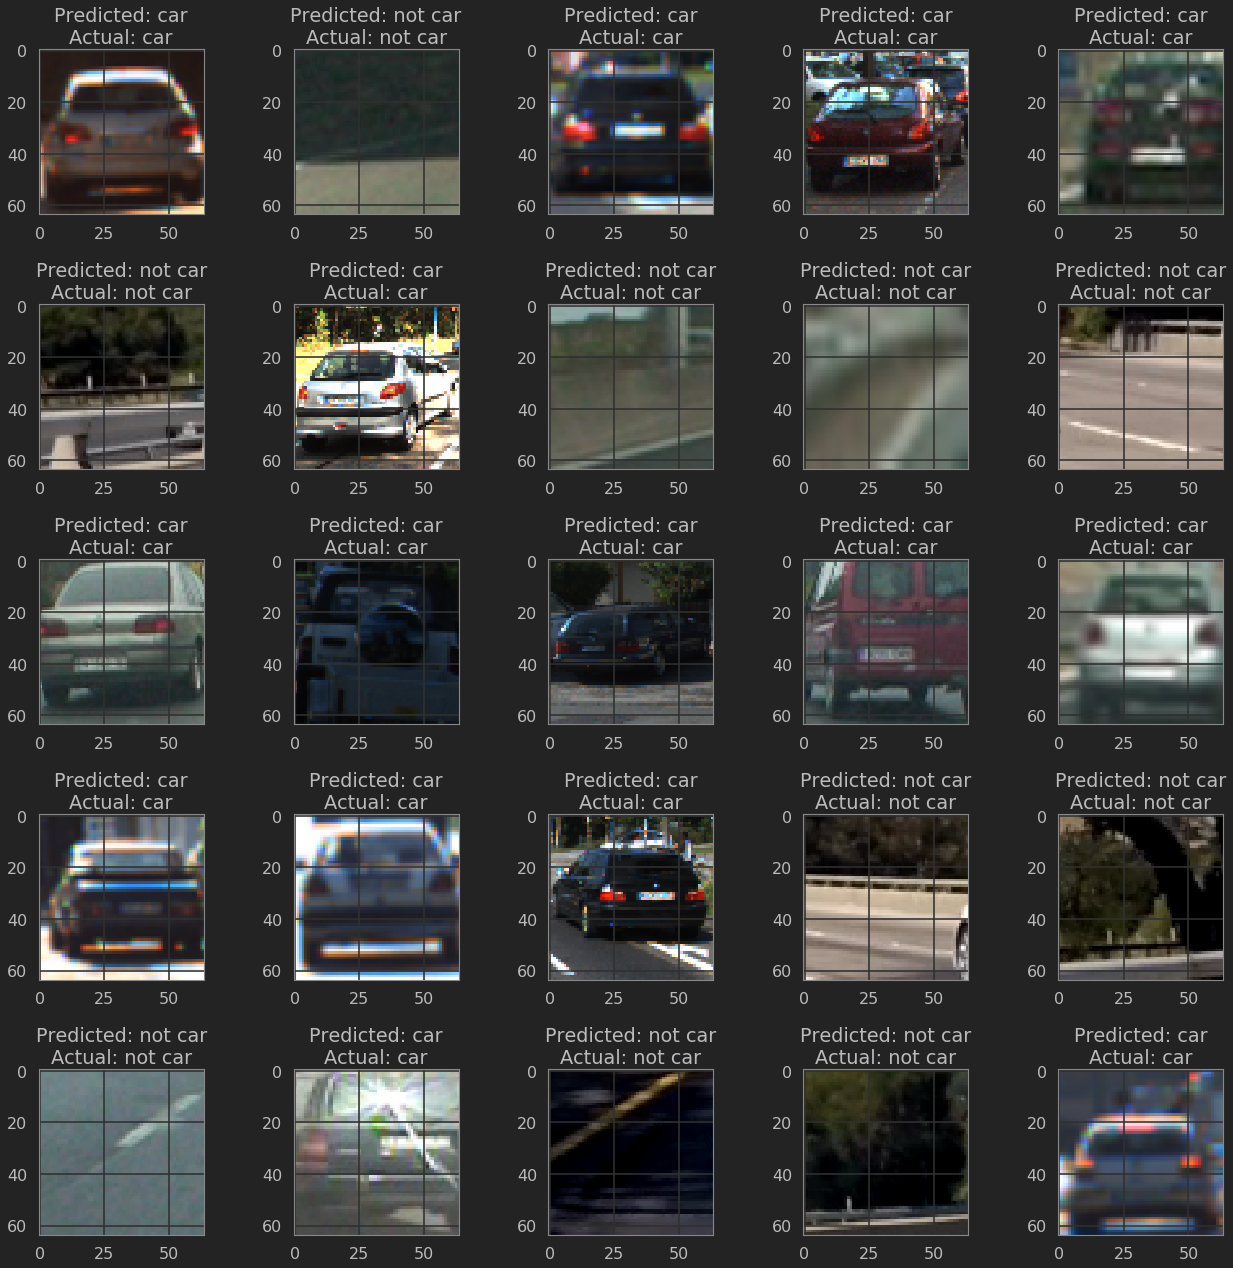

In [24]:
"lets look at some predictions and make sure they make sense"
plt.figure(figsize=(18,18))
eval_indices = np.random.randint(0, len(data), 25)
pred_disp = [predict(imread(data[x])) for x in eval_indices]
y_disp = labels[eval_indices]
for i in range(5):
    for ii in range(5):
        index = i + 5*ii
        plt.subplot(5,5,index+1)
        lbls = ["not car", "car"]
        filename = data[eval_indices[index]]
        img = imread(filename)
        actual = y_disp[index]
        predicted = pred_disp[index]
        plt.title("Predicted: {}\nActual: {}".format(lbls[int(predicted)], lbls[int(actual)]))
        plt.imshow(img)
plt.tight_layout()
plt.show()

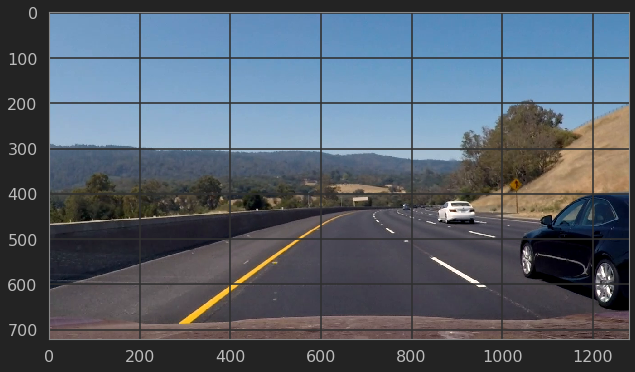

In [41]:
image = imread('../project_5/data/frames/frame_710.png')
plt.figure(figsize=(16,6))
plt.imshow(image)

In [46]:
import numpy as np

def slide_window(img, x_start_stop=[None, None], y_start_stop=[None, None], 
                    xy_window=(64, 64), xy_overlap=(0.5, 0.5)):
    # If x and/or y start/stop positions not defined, set to image size
    if x_start_stop[0] == None:
        x_start_stop[0] = 0
    if x_start_stop[1] == None:
        x_start_stop[1] = img.shape[1]
    if y_start_stop[0] == None:
        y_start_stop[0] = 0
    if y_start_stop[1] == None:
        y_start_stop[1] = img.shape[0]
    # Compute the span of the region to be searched    
    xspan = x_start_stop[1] - x_start_stop[0]
    yspan = y_start_stop[1] - y_start_stop[0]
    # Compute the number of pixels per step in x/y
    nx_pix_per_step = np.int(xy_window[0]*(1 - xy_overlap[0]))
    ny_pix_per_step = np.int(xy_window[1]*(1 - xy_overlap[1]))
    # Compute the number of windows in x/y
    nx_buffer = np.int(xy_window[0]*(xy_overlap[0]))
    ny_buffer = np.int(xy_window[1]*(xy_overlap[1]))
    nx_windows = np.int((xspan-nx_buffer)/nx_pix_per_step) 
    ny_windows = np.int((yspan-ny_buffer)/ny_pix_per_step) 
    # Initialize a list to append window positions to
    window_list = []
    # Loop through finding x and y window positions
    # Note: you could vectorize this step, but in practice
    # you'll be considering windows one by one with your
    # classifier, so looping makes sense
    for ys in range(ny_windows):
        for xs in range(nx_windows):
            # Calculate window position
            startx = xs*nx_pix_per_step + x_start_stop[0]
            endx = startx + xy_window[0]
            starty = ys*ny_pix_per_step + y_start_stop[0]
            endy = starty + xy_window[1]
            # Append window position to list
            window_list.append(((startx, starty), (endx, endy)))
    # Return the list of windows
    return window_list


def windows_xlarge(image, overlap=(.9,.9)):
    return slide_window(image,
                        x_start_stop=[900,None], 
                        y_start_stop=[390,700], 
                        xy_window=(256, 256), 
                        xy_overlap=overlap)

def windows_large(image, overlap=(.9,.9)): 
    return slide_window(image,
                        x_start_stop=[700,None], 
                        y_start_stop=[360,650], 
                        xy_window=(192, 192), 
                        xy_overlap=overlap)

def windows_medium(image, overlap=(.9,.9)): 
    return slide_window(image,
                        x_start_stop=[650,None], 
                        y_start_stop=[390,620], 
                        xy_window=(128, 128), 
                        xy_overlap=overlap)

def windows_small(image, overlap=(.85,.85)): 
    return slide_window(image,
                        x_start_stop=[620,None], 
                        y_start_stop=[390,550], 
                        xy_window=(96, 96), 
                        xy_overlap=overlap)

def windows_xsmall(image, overlap=(.8,.8)): 
    return slide_window(image,
                        x_start_stop=[600,None], 
                        y_start_stop=[390,500], 
                        xy_window=(64, 64), 
                        xy_overlap=overlap)

#define the windows
def get_windows(image,
                x_start_stop=[None, None], 
                y_start_stop=[None, None]):
    window_sets = [
        windows_xlarge(image), windows_large(image),
        windows_medium(image),
        windows_small(image), windows_xsmall(image),
    ]
    
    output = []
    for ws in window_sets:
        for window in ws:
            p1, p2 = window
            x1, y1 = p1
            x2, y2 = p2
            w = cv2.resize(image[y1:y2, x1:x2], (64,64))
            output.append((window, w))
        
    return output
    
    


def processor(window):
    bounding_box, image = window
    car = bool(clf.predict(X_scaler.transform(featurizer(image, features).reshape(1,-1)))[0])
    if car:
        return bounding_box


def get_windowed_features(image,
                x_start_stop=[None, None], 
                y_start_stop=[None, None]):
    windows = get_windows(image, x_start_stop, y_start_stop)
    global debug_windows
    debug_windows = windows
    
    return Parallel(n_jobs=num_cores)(
        delayed(processor)(w) for w in windows)

def detect_cars(image,
                x_start_stop=[None, None], 
                y_start_stop=[None, None]):
    
    windowed_features = get_windowed_features(image, x_start_stop, y_start_stop)
    return [x for x in windowed_features if x]    

In [47]:
debug_windows = []

In [48]:
def draw_boxes(img, bboxes, color=(255, 0, 255), thick=2):
    # Make a copy of the image
    imcopy = np.copy(img)
    # Iterate through the bounding boxes
    for bbox in bboxes:
        # Draw a rectangle given bbox coordinates
        cv2.rectangle(imcopy, tuple(bbox[0]), tuple(bbox[1]), color, thick)
    # Return the image copy with boxes drawn
    return imcopy


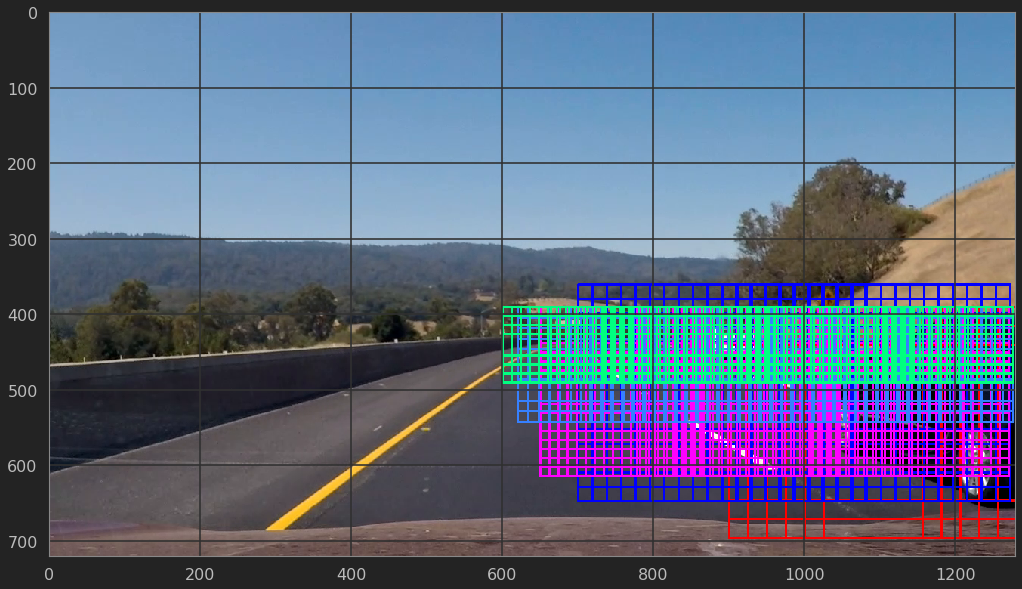

In [50]:
def draw_windows(image):
    boxed = draw_boxes(image, windows_xlarge(image, (.9,.9)), color=(256,0,0))
    boxed = draw_boxes(boxed, windows_large(image, (.9,.9)), color=(0,0,256))
    boxed = draw_boxes(boxed, windows_medium(image, (.9,.9)), color=(255,0,256))
    boxed = draw_boxes(boxed, windows_small(image, (.85,.85)), color=(54,128,256))
    boxed = draw_boxes(boxed , windows_xsmall(image, (.8,.8)), color=(0,256,128))
    
    return boxed
plt.figure(figsize=(20,10))
plt.imshow(draw_windows(image))

In [51]:
image = imread('../project_5/data/frames/frame_760.png')
detected_cars = detect_cars(image)
plt.figure(figsize=(18,6))
plt.imshow(draw_boxes(image, detected_cars))

NameError: name 'num_cores' is not defined

In [85]:
#now lets use this to create a heatmap
def add_heat(heatmap, bbox_list):
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

    # Return updated heatmap
    return heatmap

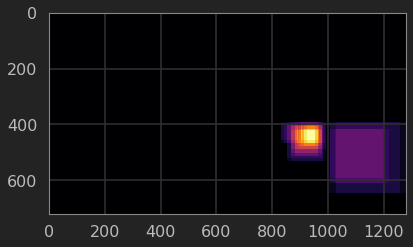

In [86]:
heatmap = add_heat(
    np.zeros_like(image[:,:,0]),
    detected_cars)
plt.imshow(heatmap, cmap="inferno")

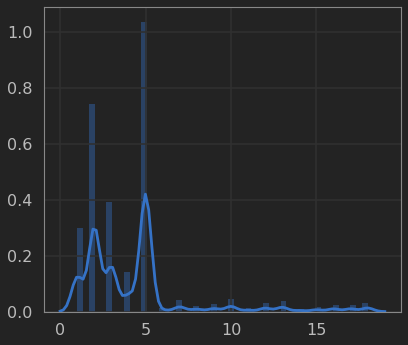

In [87]:
#lets look at this distribution so we can think about thresholding it
sns.distplot([x for x in heatmap.ravel() if x])

In [88]:
def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    output = np.copy(heatmap)
    output[output <= threshold] = 0
    return output

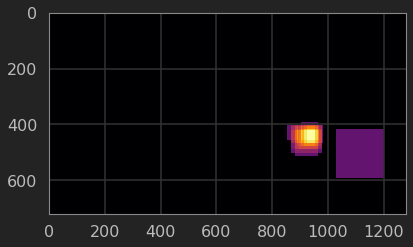

In [89]:
heatmap_thresholded = apply_threshold(heatmap, 4)
plt.imshow(heatmap_thresholded, cmap="inferno")

In [90]:
def draw_labeled_bboxes(img, labels):
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (166,266,46), 6)
    # Return the image
    return img

In [91]:
image = imread('../project_4/cnd-all/test_images/test6.jpg')

def extract_pipeline(image):
    image_cache.append(image)
    return image

def video_pipeline(image):
    global detected_cars
    global frame
#     image_cache.append(image)
#     imsave("data/frames/frame_{}.png".format(frame), image)
    
    detected_cars_this_frame = detect_cars(image)
    if len(detected_cars_this_frame):
        detected_cars.append(detected_cars_this_frame)
        detected_cars = detected_cars[-20:]
    
#     debug_cars.append(draw_boxes(image, detected_cars[-1]))
    #use the last 5 frames to build the heatmap
    
    windows_to_heat_map = [] if len(detected_cars) == 0 else np.concatenate(detected_cars)
    heatmap = add_heat(
        np.zeros_like(image[:,:,0]), windows_to_heat_map)
    
    #debug
#     debug_heat.append(heatmap)
    
    heatmap_thresholded = apply_threshold(heatmap, 50)
    labels = label(heatmap_thresholded)
    labeled_output = draw_labeled_bboxes(image, labels)
    
    frame = frame + 1
    return labeled_output

In [92]:
# #manually step through a video
# print("frame: ", frame, len(detected_cars))
# plt.figure(figsize=(18,6))
# plt.subplot(131)
# plt.imshow(video_pipeline(image_cache[frame]))
# plt.subplot(132)
# plt.imshow(debug_heat[-1], cmap="inferno")
# plt.subplot(133)
# plt.imshow(debug_cars[-1])
# frame += 1

In [93]:
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [ ]:
project_input = "../project_4/cnd-all/project_video.mp4"
project_output = "output.mp4"
frame = 0
detected_cars = []
image_cache = []
debug_cars = []
debug_heat = [] 

clip = VideoFileClip(project_input)
project_output_clip = clip.fl_image(video_pipeline)
%time project_output_clip.write_videofile(project_output, audio=False)

[MoviePy] >>>> Building video output.mp4
[MoviePy] Writing video output.mp4


  6%|▋         | 79/1261 [04:44<1:08:50,  3.49s/it]

In [ ]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>|
""".format(project_output))

In [ ]:
#notes, fast global seach  until objects are detected and then tageted fine search
#need smaller search boxes at horizon
#augment data with partial car pictures for when they appear on the sides
#work on window layout
# doesnt see cars on the horizon




In [ ]:
##### the final test
hot_dog_car = imread("hot_dog_car.jpg")
plt.imshow(hot_dog_car)

In [ ]:
clip = VideoFileClip(project_input)
project_output_clip = clip.fl_image(pipeline)
%time project_output_clip.write_videofile(project_output, audio=False)